In [ ]:
# Importations
import warnings
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

warnings.filterwarnings("ignore")

In [2]:
# Loading the btc data
df = pd.read_csv("btc_data.csv")
df.head()

,Date,Close,High,Low,Open,Volume
0,2020-07-01,9228.325195,9309.754883,9104.735352,9145.985352,15971550355
1,2020-07-02,9123.410156,9274.962891,9036.623047,9231.139648,16338916796
2,2020-07-03,9087.303711,9202.344727,9058.794922,9124.842773,13078970999
3,2020-07-04,9132.488281,9183.295898,9053.629883,9084.233398,12290528515
4,2020-07-05,9073.942383,9162.183594,8977.015625,9126.090820,12903406143


In [3]:
# Taking our intrested column
y = (df["Close"])
y.index = df["Date"]
y.name = "BTC Close"
y.index = pd.to_datetime(y.index)
y.head()

Date
2020-07-01    9228.325195
2020-07-02    9123.410156
2020-07-03    9087.303711
2020-07-04    9132.488281
2020-07-05    9073.942383
Name: BTC Close, dtype: float64

In [4]:
y.index = y.index.tz_localize("UTC").tz_convert("America/Los_Angeles")
y.index

DatetimeIndex(['2020-06-30 17:00:00-07:00', '2020-07-01 17:00:00-07:00',
               '2020-07-02 17:00:00-07:00', '2020-07-03 17:00:00-07:00',
               '2020-07-04 17:00:00-07:00', '2020-07-05 17:00:00-07:00',
               '2020-07-06 17:00:00-07:00', '2020-07-07 17:00:00-07:00',
               '2020-07-08 17:00:00-07:00', '2020-07-09 17:00:00-07:00',
               ...
               '2025-07-01 17:00:00-07:00', '2025-07-02 17:00:00-07:00',
               '2025-07-03 17:00:00-07:00', '2025-07-04 17:00:00-07:00',
               '2025-07-05 17:00:00-07:00', '2025-07-06 17:00:00-07:00',
               '2025-07-07 17:00:00-07:00', '2025-07-08 17:00:00-07:00',
               '2025-07-09 17:00:00-07:00', '2025-07-10 17:00:00-07:00'],
              dtype='datetime64[ns, America/Los_Angeles]', name='Date', length=1837, freq=None)

In [5]:
y.head()

Date
2020-06-30 17:00:00-07:00    9228.325195
2020-07-01 17:00:00-07:00    9123.410156
2020-07-02 17:00:00-07:00    9087.303711
2020-07-03 17:00:00-07:00    9132.488281
2020-07-04 17:00:00-07:00    9073.942383
Name: BTC Close, dtype: float64

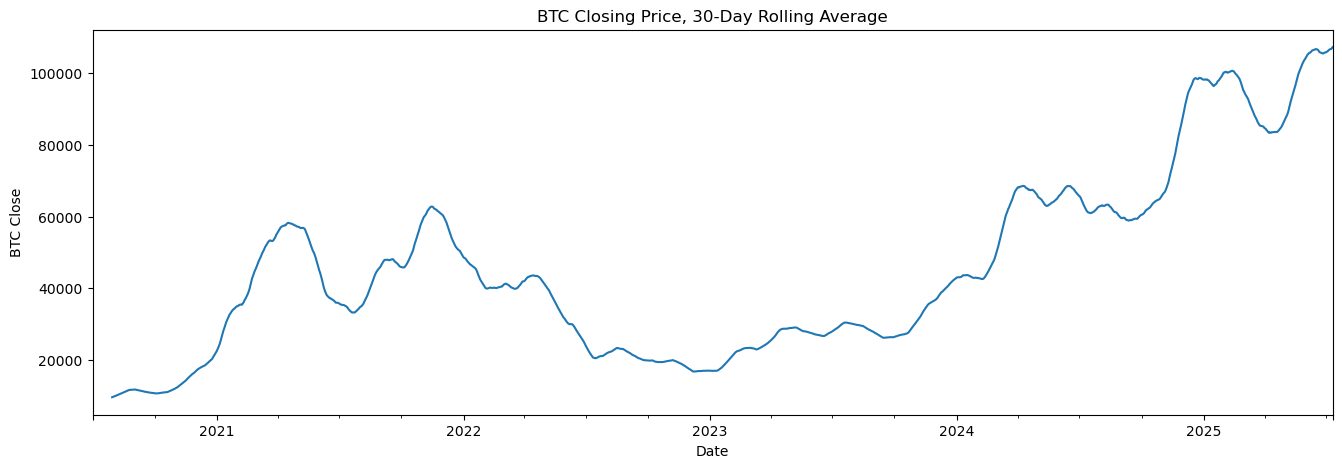

In [6]:
# Plotting the 30 days rolling average
fig, ax = plt.subplots(figsize=(16, 5))
y.rolling(30).mean().plot(xlabel="Date", ylabel="BTC Close", title="BTC Closing Price, 30-Day Rolling Average", ax=ax);

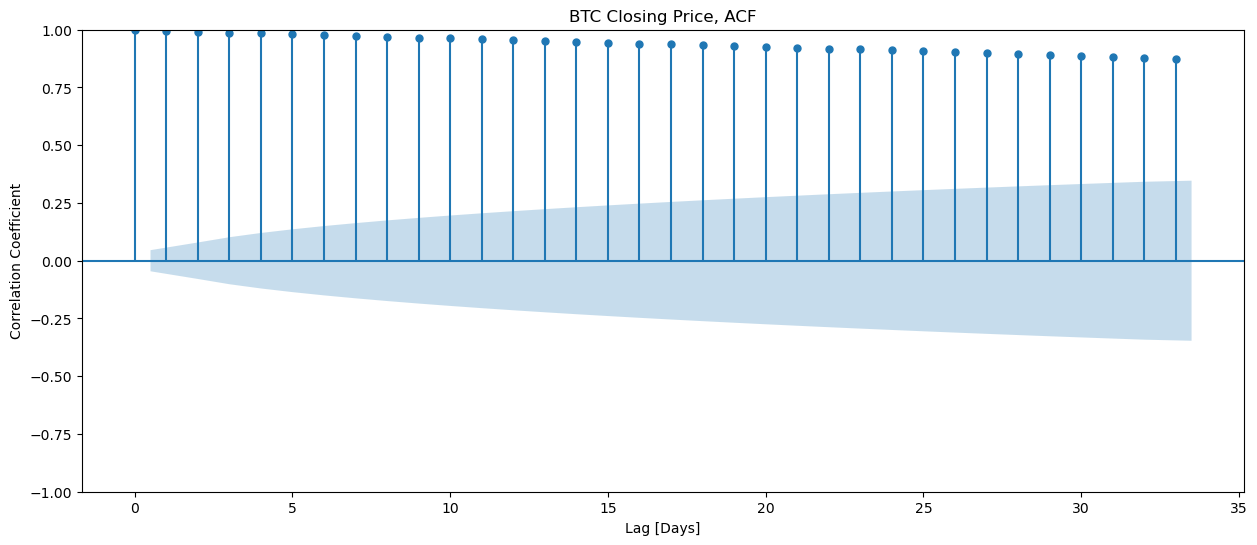

In [7]:
# Plotting the ACF plot
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y, ax=ax)
plt.xlabel("Lag [Days]")
plt.ylabel("Correlation Coefficient")
plt.title("BTC Closing Price, ACF");

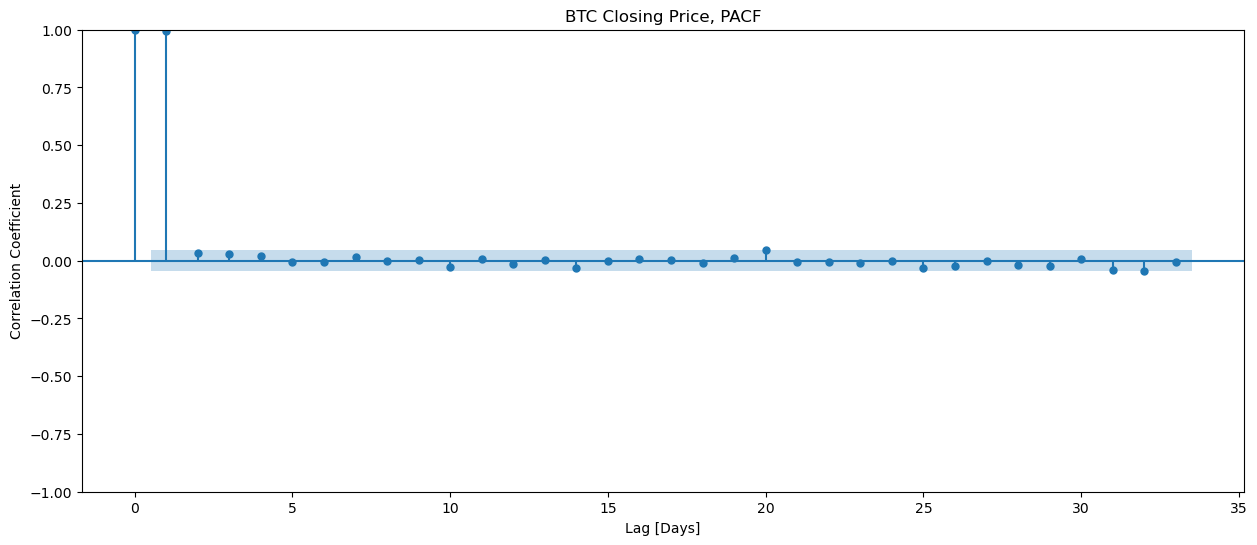

In [8]:
# Plotting the PACF plot
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax=ax)
plt.xlabel("Lag [Days]")
plt.ylabel("Correlation Coefficient")
plt.title("BTC Closing Price, PACF");

In [9]:
len(y)

1837

In [10]:
# Splitting the data
cutoff = int(len(y) * 0.9)
y_train = y.iloc[: cutoff]
y_test = y.iloc[cutoff :]

# Testing the split
len(y_train) + len(y_test) == len(y)

True

In [11]:
# Calculating the Baseline
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean BTC Close Reading:", round(y_mean, 2))
print("MAE Baseline:", round(mae_baseline, 2))

Mean BTC Close Reading: 39679.92
MAE Baseline: 16640.15


In [12]:
y_train.isnull().sum()

0

In [13]:
# Hyperparametering the model is 'hyperparametering' even a word?
p_params = range(1, 34)
maes = []

for p in p_params:
    model = AutoReg(y_train, lags=p).fit()
    y_pred = model.predict().dropna()
    model_mae = mean_absolute_error(y_train.iloc[p:], y_pred)
    maes.append(model_mae)

mae_series = pd.Series(maes, name="mae", index=p_params)
mae_series.head()

1    895.445573
2    893.414807
3    894.302344
4    894.831513
5    895.198657
Name: mae, dtype: float64

In [14]:
# Checking for the lowest mae using their index which is also P
mae_series.idxmin()

2

In [15]:
# Training our model using the lag parameter = 2
best_p = 2
best_model = AutoReg(y_train, lags=best_p).fit()
type(best_model)

statsmodels.tsa.ar_model.AutoRegResultsWrapper

In [16]:
# Getting the residuals
y_train_resid = best_model.resid
y_train_resid.name = "residuals"
y_train_resid.head()

Date
2020-07-02 17:00:00-07:00   -113.755467
2020-07-03 17:00:00-07:00    -29.882615
2020-07-04 17:00:00-07:00   -130.506438
2020-07-05 17:00:00-07:00    225.606916
2020-07-06 17:00:00-07:00   -185.296559
Name: residuals, dtype: float64

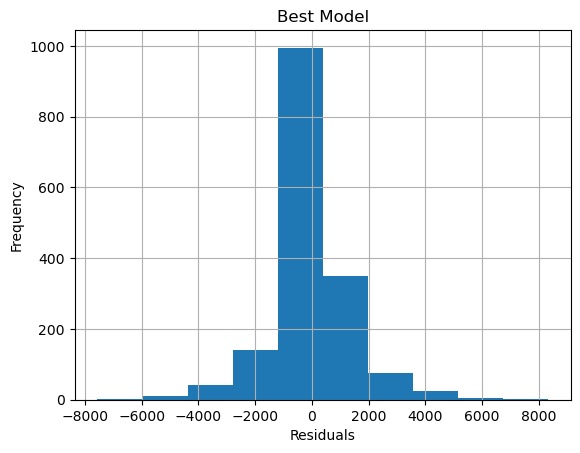

In [17]:
# Plotting the residuals
y_train_resid.hist()
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Best Model")
plt.show()

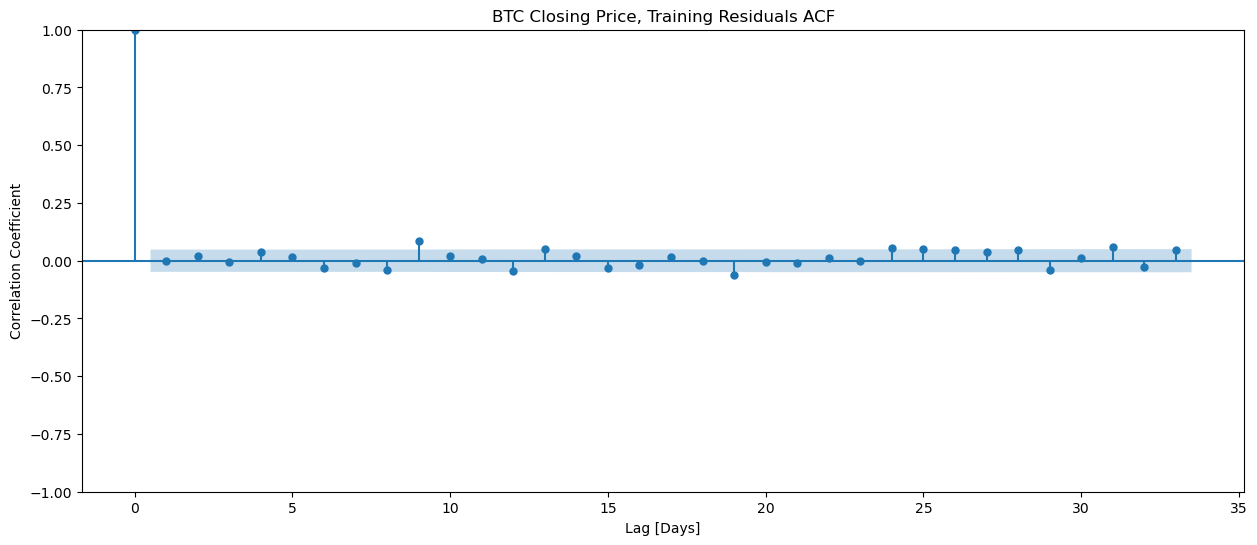

In [18]:
# Checking the ACF of the residuals
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid, ax=ax)
plt.xlabel("Lag [Days]")
plt.ylabel("Correlation Coefficient")
plt.title("BTC Closing Price, Training Residuals ACF");

In [19]:
# Performing walk forward validation
y_pred_wfv = pd.Series()
history = y_train.copy()

for i in range(len(y_test)):
    model = AutoReg(history, lags=best_p).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])

y_pred_wfv.name = "Prediction"
y_pred_wfv.index.name = "timestamp"
y_pred_wfv.head()

timestamp
2025-01-08 16:00:00-08:00    95133.135414
2025-01-09 16:00:00-08:00    92583.118258
2025-01-10 16:00:00-08:00    94632.851618
2025-01-11 16:00:00-08:00    94587.001808
2025-01-12 16:00:00-08:00    94506.256794
Freq: 24H, Name: Prediction, dtype: float64

In [20]:
y_test.head()

Date
2025-01-08 16:00:00-08:00    92484.039062
2025-01-09 16:00:00-08:00    94701.453125
2025-01-10 16:00:00-08:00    94566.593750
2025-01-11 16:00:00-08:00    94488.437500
2025-01-12 16:00:00-08:00    94516.523438
Name: BTC Close, dtype: float64

In [21]:
# Putting walk forward validation into a dataframe
df_pred_test = pd.DataFrame({
    "y_test": y_test,
    "y_pred_wfv": y_pred_wfv
})

df_pred_test.head()

,y_test,y_pred_wfv
2025-01-08 16:00:00-08:00,92484.039062,95133.135414
2025-01-09 16:00:00-08:00,94701.453125,92583.118258
2025-01-10 16:00:00-08:00,94566.593750,94632.851618
2025-01-11 16:00:00-08:00,94488.437500,94587.001808
2025-01-12 16:00:00-08:00,94516.523438,94506.256794


In [22]:
# Plotting walk forward validation
fig = px.line(df_pred_test)
fig.update_layout(xaxis_title="Date",
                  yaxis_title="BTC Closing Price",
                  title="BTC Closing Price, WFV Predictions")
fig.show();